### Кластеризация методом k-средних 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # для стилизации графиков       
import numpy as np 

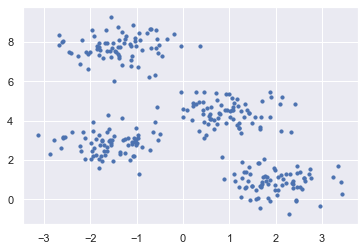

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, 
                      cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1], s=10);

In [3]:
from sklearn.cluster import KMeans

In [4]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [5]:
y_kmeans = kmeans.predict(X)

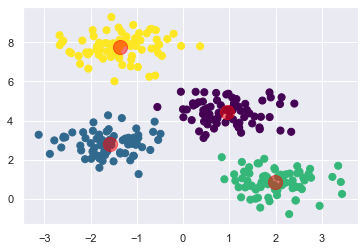

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_       
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5);


#### Алгоритм k-средних: максимизация математического ожидания


In [7]:
from sklearn.metrics import pairwise_distances_argmin
def find_clusters(X, n_clusters, rseed=2):
     # 1. Выбираем кластеры случайным образом           
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]           
    centers = X[i]
    while True:
        # 2a. Присваиваем метки в соответствии с ближайшим центром 
        labels = pairwise_distances_argmin(X, centers)
        # 2b. Находим новые центры, исходя из средних значений точек
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
        # 2c. Проверяем сходимость               
        if np.all(centers == new_centers):                   
            break               
        centers = new_centers
    return centers, labels

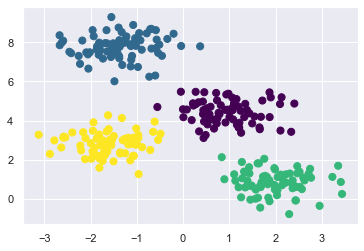

In [8]:
centers, labels = find_clusters(X, 4)       
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');


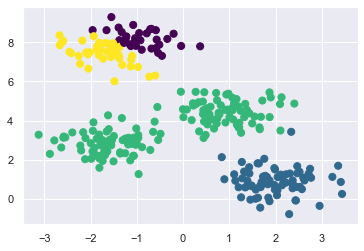

In [9]:
centers, labels = find_clusters(X, 4, rseed=3)       
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');


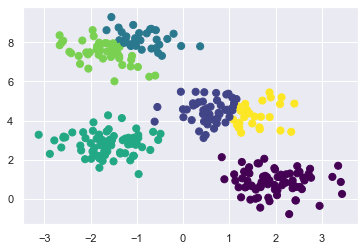

In [10]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=50, cmap='viridis')

In [11]:
from sklearn.datasets import make_moons       
X, y = make_moons(200, noise=.05, random_state=0)


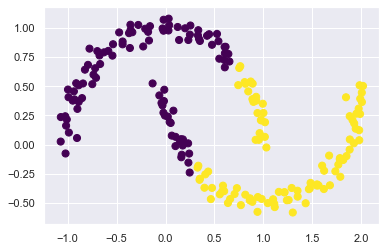

In [12]:
labels = KMeans(2, random_state=0).fit_predict(X)       
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


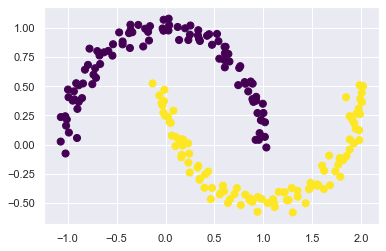

In [13]:
from sklearn.cluster import SpectralClustering 
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis'); 

#### Пример 1: применение метода k-средних для рукописных цифр


In [14]:
from sklearn.datasets import load_digits
digits = load_digits()  
digits.data.shape


(1797, 64)

In [15]:
kmeans = KMeans(n_clusters=10, random_state=0)

In [16]:
clusters = kmeans.fit_predict(digits.data)

In [17]:
kmeans.cluster_centers_.shape

(10, 64)

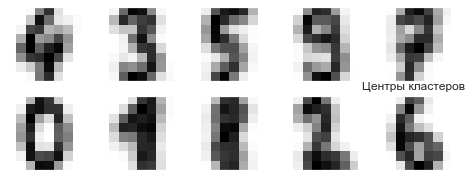

In [18]:

fig, ax = plt.subplots(2, 5, figsize=(8,3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)
plt.title('Центры кластеров');

In [19]:
# упорядочим метки
from scipy.stats import mode # возвращает моду
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [21]:
accuracy_score(digits.target, labels)

0.7935447968836951

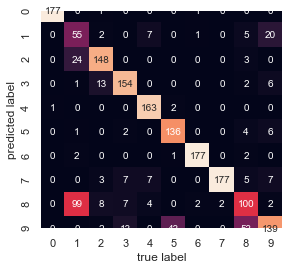

In [22]:
mat = confusion_matrix(digits.target, labels)        
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names, yticklabels=digits.target_names)        
plt.xlabel('true label')        
plt.ylabel('predicted label');


Воспользуемся для предварительной обработки данных до выполнения k-средних алгоритмом стохастического вложения соседей на основе распределения Стьюдента (t-SNE)

In [23]:
from sklearn.manifold import TSNE
# проекция данных, выполняется долго
tsne = TSNE(n_components=2, init='pca', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

In [24]:
# расчет кластеров
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# перестановка меток
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [25]:
accuracy_score(digits.target, labels)

0.9398998330550918

#### Пример 2: использование метода k-средних  для сжатия цветов 

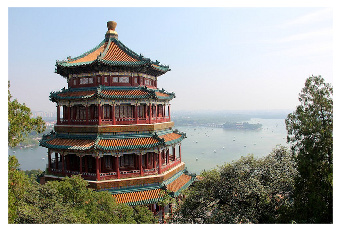

In [26]:
from sklearn.datasets import load_sample_image        
china = load_sample_image("china.jpg")        
ax = plt.axes(xticks=[], yticks=[])        
ax.imshow(china);


In [27]:
china.shape

(427, 640, 3)

In [28]:
data = china / 255.0 # используем шкалу 0...255
data = data.reshape(427 * 640, 3)

In [29]:
def plot_pixels(data, title, colors=None, N=10000):            
    if colors is None:                
        colors = data            
    # Выбираем случайное подмножество            
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]            
    colors = colors[i]            
    R, G, B = data[i].T 
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))            
    ax[0].scatter(R, G, color=colors, marker='.')            
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))
    ax[1].scatter(R, B, color=colors, marker='.')            
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))
    fig.suptitle(title, size=20);

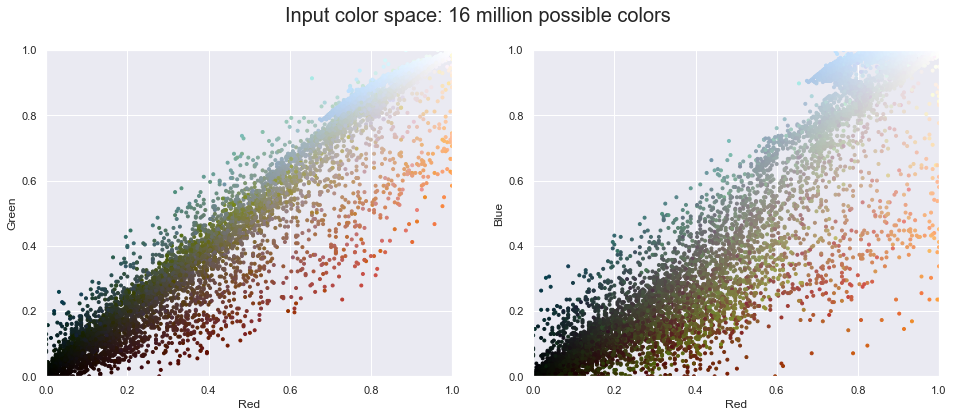

In [30]:
plot_pixels(data, 
            title='Input color space: 16 million possible colors') # Исходное цветовое пространство: 16 миллионов                              # возможных цветов


In [31]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=16)
kmeans.fit(data)
kmeans.predict(data)


array([ 5,  5,  5, ...,  2,  8, 14])

In [32]:
kmeans.predict(data).shape

(273280,)

In [33]:
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
new_colors.shape

(273280, 3)

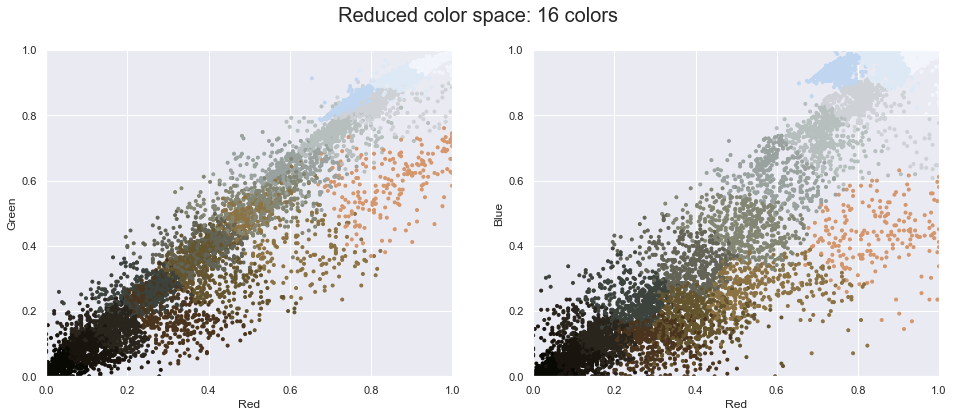

In [34]:
plot_pixels(data, 
            colors=new_colors, 
            title="Reduced color space: 16 colors") # Редуцированное цветовое пространство: 16 цветов

Text(0.5, 1.0, '16-цветное изображение')

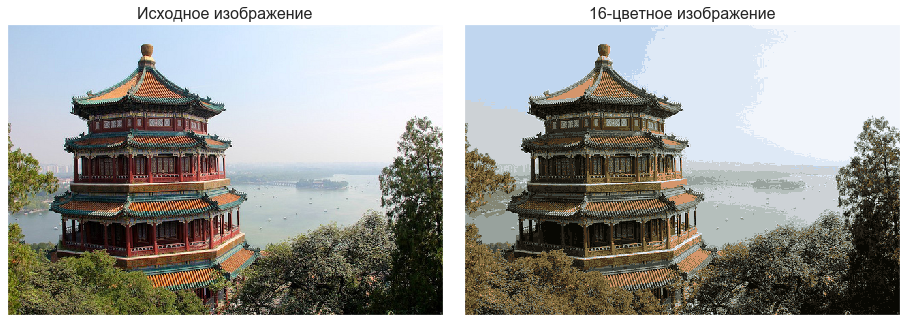

In [35]:
china_recolored = new_colors.reshape(china.shape)
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                      subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Исходное изображение', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-цветное изображение', size=16)

### Смеси Гауссовых распределений (GMM)

In [36]:
# генерируем данные
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                      cluster_std=0.60, random_state=0)
X.shape

(400, 2)

In [37]:
X[:, ::-1].shape

(400, 2)

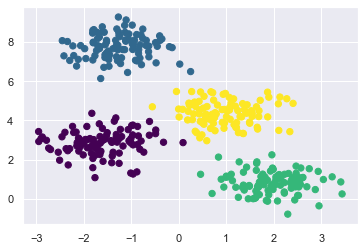

In [38]:
# смотрим на работу KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='viridis');

In [39]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0], X[:,1], c=labels, s=20, cmap='viridis', zorder=2)
    
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels==i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='red', lw=3, alpha=0.5, zorder=1))

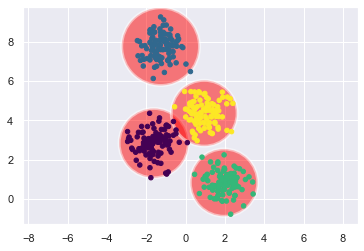

In [40]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

In [41]:
rng = np.random.RandomState(13)


In [42]:
X.shape

(400, 2)

In [43]:
rng.randn(2,2)

array([[-0.71239066,  0.75376638],
       [-0.04450308,  0.45181234]])

In [44]:
X_streched = np.dot(X, rng.randn(2,2))

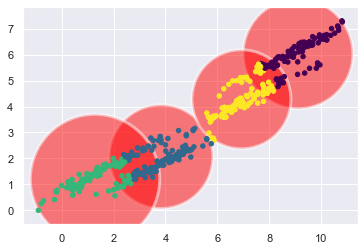

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_streched)

In [46]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)

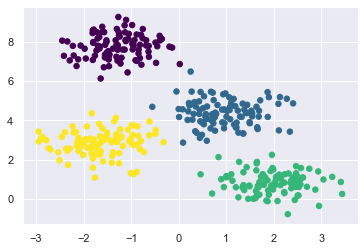

In [47]:
labels = gmm.predict(X)
plt.scatter(X[:,0], X[:,1], c=labels, s=30, cmap='viridis');

In [48]:
# матрица [n_samples, n_clusters] содержит оценки вероятностей принадлежности точки к конкретному кластеру
probs = gmm.predict_proba(X)
print(probs[:10].round(3))

[[0.463 0.537 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.987 0.    0.013]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


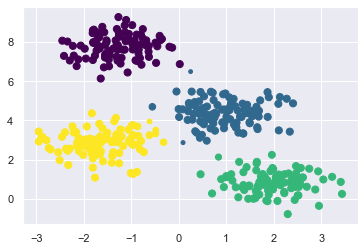

In [49]:
size = 50 * probs.max(1) ** 2 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [50]:
from matplotlib.patches import Ellipse
def draw_ellipse(position, covariance, ax=None, **kwargs):    
    """Рисует эллипс с заданными расположением и ковариацией"""    
    ax = ax or plt.gca()
    # Преобразуем ковариацию к главным осям координат    
    if covariance.shape == (2, 2):        
        U, s, Vt = np.linalg.svd(covariance)        
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))        
        width, height = 2 * np.sqrt(s)    
    else:        
        angle = 0        
        width, height = 2 * np.sqrt(covariance)
    # Рисуем эллипс    
    for nsig in range(1, 4):        
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,                             
                             angle, **kwargs))


In [51]:
def plot_gmm(gmm, X, label=True, ax=None):    
    ax = ax or plt.gca()    
    labels = gmm.fit(X).predict(X)    
    if label:        
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)    
    else:        
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)    
    ax.axis('equal')    
    w_factor = 0.2 / gmm.weights_.max()    
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):        
        draw_ellipse(pos, covar, alpha=w * w_factor) 

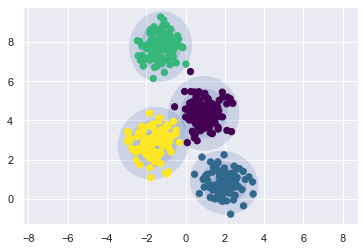

In [52]:
gmm = GMM(n_components=4, random_state=42)        
plot_gmm(gmm, X)

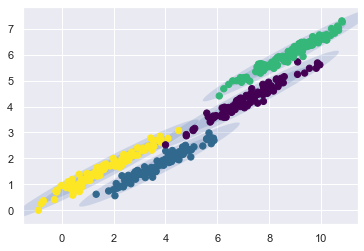

In [53]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)        
plot_gmm(gmm, X_streched)

### GMM как метод оценки плотности распределения

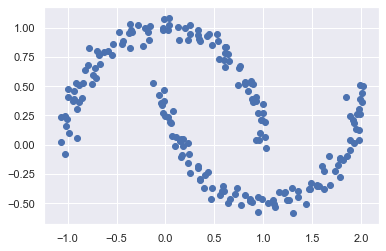

In [54]:
from sklearn.datasets import make_moons        
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)        
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);


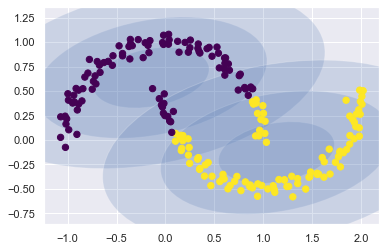

In [55]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)        
plot_gmm(gmm2, Xmoon)

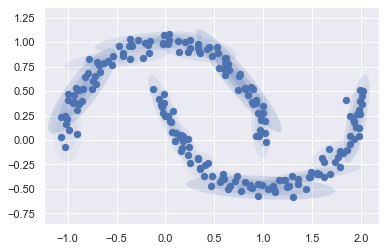

In [56]:
# возьмем больше компонент
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)        
plot_gmm(gmm16, Xmoon, label=False)


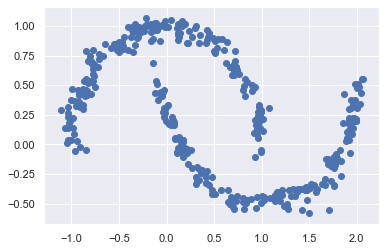

In [57]:
# создадим новые 400 точек, порожденных моделью gmm16
Xnew = gmm16.sample(400)        
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

In [58]:
Xnew[0].shape

(400, 2)

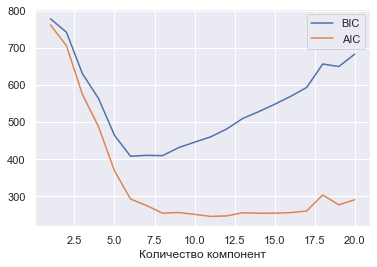

In [59]:
# оценим модели по информационным критериям (Акаике и Шварца).
# критерий помогает найти лучшу модель по соотношению сложность/точность
n_components = np.arange(1,21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon) for n in n_components]
plt.plot(n_components, [m.bic(Xmoon) for m in models], label = 'BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label = 'AIC')
plt.legend(loc='best')
plt.xlabel('Количество компонент');

#### Пример: использование метода GMM для генерации новых данных 

In [60]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [85]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(10,10),
                          subplot_kw = dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.15)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8,8), cmap='binary')
        im.set_clim(0, 8)

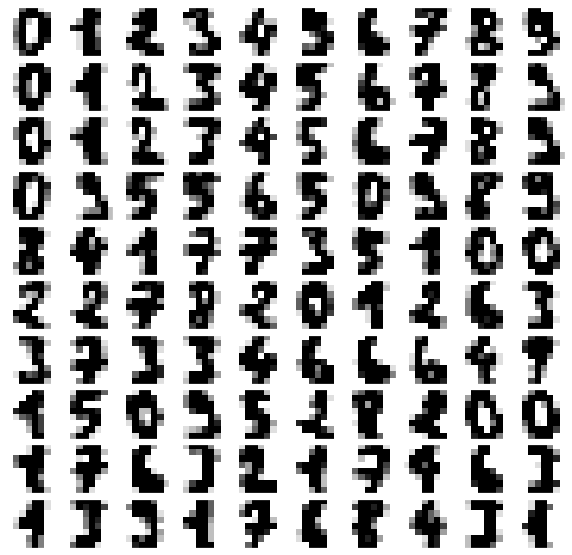

In [86]:
plot_digits(digits.data)

In [87]:
# сейчас данные 64-мерные, понизим размерность с сохранением 99% дисперсии
from sklearn.decomposition import PCA

In [88]:
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

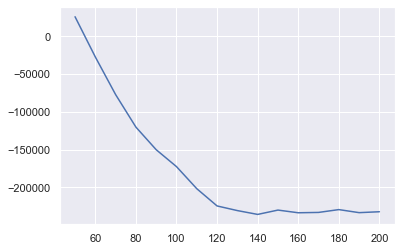

In [89]:
# для определение количества компонент воспользуемся критерием Акаике
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0) 
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [93]:
# минимальный AIC при 140 компонентах. обучим на них алгоритм GMM
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=110, n_init=1,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [97]:
# сгенерируем новые точки
data_new = gmm.sample(100)
type(data_new)

tuple

In [102]:
data_new[0].shape
print('data_new[0].shape ', data_new[0].shape)
print('Мы получили {0} точек в {1}-мерном пространстве'.format(data_new[0].shape[0], data_new[0].shape[1]))

data_new[0].shape  (100, 41)
Мы получили 100 точек в 41-мерном пространстве


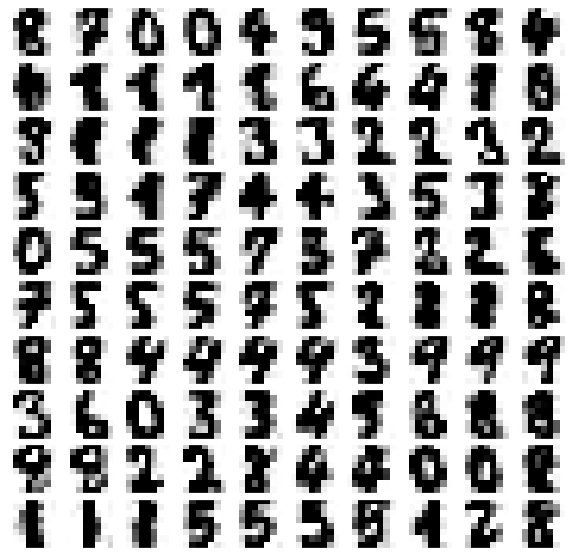

In [104]:
# Используем обратное преобразование PCA для формирования новых цифр
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)